# Discharge Notes and Readmission Rates: NLP

This notebook is for the processing the cleaned dataset through a NLP.

## Import

Import the relevant libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords

#modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xg
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.utils import class_weight

# Neural network models and layers
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    array_to_img,
    img_to_array,
    load_img
)
from tensorflow.keras.models import load_model

## Functions

In [2]:
def scores(model, X, y, set_type):
    '''
    This function takes in an already fitted model, X, y, and
    the type of data (train, validation, or test) in str format,
    and prints out the accuracy and recall scores. The function
    also prints out the confusion matrix
    '''
    pred = model.predict(X)
    acc_score = accuracy_score(y, pred)
    rec_score = recall_score(y, pred)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", acc_score)
    print("recall:   ", rec_score)
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_title(set_type)
    plot_confusion_matrix(model, X, y, ax=ax)
    return round(acc_score*100,1), round(rec_score*100,1) 

In [233]:
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

In [270]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('Irrelevant', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Readmission', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()
    return fig

## Reading in the Data

Here, I read in the cleand dataset from the previous EDA folder.

In [3]:
df = pd.read_csv('data/admissions_cleaned_2.csv.gz', compression='gzip')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52726 entries, 0 to 52725
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ADMISSION_TYPE      52726 non-null  object
 1   ADMISSION_LOCATION  52726 non-null  object
 2   DISCHARGE_LOCATION  52726 non-null  object
 3   INSURANCE           52726 non-null  object
 4   LANGUAGE            52726 non-null  object
 5   RELIGION            52726 non-null  object
 6   MARITAL_STATUS      52726 non-null  object
 7   ETHNICITY           52726 non-null  object
 8   DIAGNOSIS           52726 non-null  object
 9   READMISSION         52726 non-null  int64 
 10  GENDER              52726 non-null  object
 11  AGE                 52726 non-null  int64 
 12  TEXT                52726 non-null  object
 13  CPT_CD              52726 non-null  object
 14  DIAG_ICD9_CODE      52722 non-null  object
 15  DRG_CODE            52726 non-null  object
 16  PROCED_ICD9_CODE    52

In [5]:
df['READMISSION'].value_counts()

0    49715
1     3011
Name: READMISSION, dtype: int64

In [6]:
#set X as the text data, and y as the readmission status
X = df['TEXT']
y = df['READMISSION']

The dataset is heavily imbalanced, with a lot more negative cases. In order to handle class imbalance, I will later on use two method, SMOTE and undersampling, to mitigate the class imbalance.

In [183]:
pos_df = df[df['READMISSION']==1]
neg_df = df[df['READMISSION']==0]

pos_X = pos_df['TEXT']
neg_X = neg_df['TEXT']

In [184]:
sw = stopwords.words('english')

In [185]:
count_vec = CountVectorizer(stop_words=sw, max_features=20)
count_vec.fit(pos_X)
tfidf_vec = TfidfVectorizer(stop_words=sw, max_features=20)
tfidf_vec.fit(pos_X)

TfidfVectorizer(max_features=20,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [186]:
bag_of_words = count_vec.transform(pos_X)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]

In [187]:
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [188]:
words_freq

[('wa', 92468),
 ('mg', 62254),
 ('tablet', 49487),
 ('name', 44193),
 ('po', 38759),
 ('patient', 38190),
 ('day', 36165),
 ('blood', 30941),
 ('daili', 30698),
 ('sig', 30287),
 ('hospit', 30107),
 ('discharg', 28908),
 ('one', 28050),
 ('hi', 23451),
 ('last', 22205),
 ('left', 19877),
 ('time', 19726),
 ('histori', 19553),
 ('medic', 18721),
 ('right', 16648)]

In [189]:
bag_of_words = tfidf_vec.transform(pos_X)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]

In [190]:
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [191]:
words_freq

[('wa', 1290.5287234051336),
 ('mg', 871.3013923889422),
 ('tablet', 804.1657326770642),
 ('name', 645.0082322563459),
 ('po', 608.3590456987669),
 ('sig', 577.7954051727461),
 ('patient', 540.0631147608569),
 ('day', 508.5686892971026),
 ('daili', 488.2984323106088),
 ('blood', 457.0502122205831),
 ('hi', 457.0293652051453),
 ('discharg', 448.07359532825285),
 ('hospit', 430.2582768650136),
 ('one', 412.9495024515257),
 ('last', 327.39407060661966),
 ('left', 320.66391113281975),
 ('histori', 300.6325752068569),
 ('time', 284.0022529635785),
 ('medic', 282.22004013925005),
 ('right', 270.5921505742682)]

In [192]:
bag_of_words = tfidf_vec.transform(pos_X)
sum_words = bag_of_words.mean(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]

In [193]:
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [194]:
words_freq

[('wa', 0.428604690602834),
 ('mg', 0.2893727639949993),
 ('tablet', 0.26707596568484304),
 ('name', 0.21421728072279805),
 ('po', 0.20204551501121498),
 ('sig', 0.19189485392651778),
 ('patient', 0.17936337255425355),
 ('day', 0.16890358329362437),
 ('daili', 0.16217151521441706),
 ('blood', 0.15179349459335192),
 ('hi', 0.15178657097480702),
 ('discharg', 0.14881222030164454),
 ('hospit', 0.14289547554467397),
 ('one', 0.1371469619566674),
 ('last', 0.10873267041070082),
 ('left', 0.10649747961900372),
 ('histori', 0.09984476094548557),
 ('time', 0.09432157189092631),
 ('medic', 0.09372967125182659),
 ('right', 0.08986786800872411)]

In [195]:
count_vec = CountVectorizer(stop_words=sw, max_features=20)
count_vec.fit(neg_X)
tfidf_vec = TfidfVectorizer(stop_words=sw, max_features=20)
tfidf_vec.fit(neg_X)

TfidfVectorizer(max_features=20,
                stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours',
                            'ourselves', 'you', "you're", "you've", "you'll",
                            "you'd", 'your', 'yours', 'yourself', 'yourselves',
                            'he', 'him', 'his', 'himself', 'she', "she's",
                            'her', 'hers', 'herself', 'it', "it's", 'its',
                            'itself', ...])

In [196]:
bag_of_words = count_vec.transform(neg_X)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]

In [197]:
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [198]:
words_freq

[('wa', 1330069),
 ('mg', 708879),
 ('name', 598701),
 ('tablet', 571799),
 ('patient', 551299),
 ('day', 451690),
 ('discharg', 429881),
 ('po', 426041),
 ('blood', 421949),
 ('hospit', 386824),
 ('daili', 341370),
 ('sig', 328805),
 ('one', 317875),
 ('hi', 307543),
 ('left', 297917),
 ('last', 296251),
 ('histori', 288925),
 ('medic', 269838),
 ('right', 244917),
 ('time', 238934)]

In [199]:
bag_of_words = tfidf_vec.transform(neg_X)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]

In [200]:
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [201]:
words_freq

[('wa', 22613.913608098177),
 ('mg', 11775.713684677012),
 ('tablet', 11649.601009582482),
 ('name', 10496.17696113363),
 ('patient', 9709.86742204662),
 ('discharg', 8214.825183635076),
 ('po', 8152.055769137717),
 ('day', 7747.505670747808),
 ('sig', 7598.2045074933885),
 ('blood', 7507.176765868078),
 ('hi', 7353.392296289479),
 ('daili', 6744.407506566189),
 ('hospit', 6628.999086727088),
 ('left', 5875.341570252123),
 ('one', 5631.26701524174),
 ('histori', 5420.169536571897),
 ('last', 5303.157393770275),
 ('right', 4961.549601340353),
 ('medic', 4916.650401199442),
 ('time', 4222.045523161933)]

In [202]:
bag_of_words = tfidf_vec.transform(neg_X)
sum_words = bag_of_words.mean(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in count_vec.vocabulary_.items()]

In [203]:
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

In [204]:
words_freq

[('wa', 0.4548710370732754),
 ('mg', 0.23686440077797669),
 ('tablet', 0.23432768801332488),
 ('name', 0.21112696291126642),
 ('patient', 0.1953106189690556),
 ('discharg', 0.16523836233802855),
 ('po', 0.16397577731344126),
 ('day', 0.15583839225078516),
 ('sig', 0.15283525108102894),
 ('blood', 0.1510042595970642),
 ('hi', 0.1479109382739515),
 ('daili', 0.13566142022661482),
 ('hospit', 0.13334001984767527),
 ('left', 0.1181804600271975),
 ('one', 0.11327098491887132),
 ('histori', 0.10902483227540734),
 ('last', 0.10667117356472527),
 ('right', 0.09979985117852484),
 ('medic', 0.0988967193241374),
 ('time', 0.08492498286557192)]

## Train, Validation, and Test Split

I split the data set into three sets: Train, Validation, and Test.
The ratio I used was 70:15:15.

In [7]:
X_train, X_v_t, y_train, y_v_t = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [8]:
X_val, X_test, y_val, y_test = train_test_split(X_v_t, y_v_t, test_size=0.50, random_state=42, stratify=y_v_t)

In [9]:
X_train.shape

(36908,)

## Pipeline Parameters

In this section, I set specific pipeline parameters that I will keep constant throughout the project.

In [ ]:
sw = stopwords.words('english')

#setting the number of maximum features as 10% of rows in X
max_feats = int(X_train.shape[0]*0.10)

## Modeling

In this section, I will run several different models. Once I decide the best model, I will export the results out so that in another notebook, I can merge that results to other data features and run that through models again to see if I can get a better model.

### Model 0: Dummy Classification

For my Model 0, I run a simple dummy classifier. I test out both a count vectorizer and a tfidf vectorizer to see if it will impact the results. I have yet to do anything about the class imbalance.

* Model: Dummy
* Vectorizer: Count
* Class Imbalance Solution: None

In [ ]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified"))
    ])

In [ ]:
pp_count.fit(X_train, y_train)

scores(pp_count, X_train, y_train, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Dummy
* Vectorizer: Tfidf
* Class Imbalance Solution: None

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('dummy', DummyClassifier(random_state=42, strategy="stratified")),   
    ])

In [ ]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

Though the accuracy is high for both the vectorizers through the dummy classifier model, the recall score was very poor. This is most likely due to the class imbalance. However, I will run a non-dummy, but simple logistic regression model to validate that the low recall score is not because of the dummy model itself.

### Model 1: Logistic Regression

The next model I decided to use is the logitic regression model.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: None

In [ ]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

In [ ]:
pp_count.fit(X_train, y_train)

scores(pp_count, X_train, y_train, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: None

In [ ]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

In [ ]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

Again, the accuracy scores are high, but the recall scores are poor. Thus, for the next modeling step, I will try to improve the model by first trying to mitigate the class imbalance.

### Handling Imbalanced Data 

As mentioned before, the dataset is heavily imbalanced. I will implement three methods to handle the class imbalance:
* Undersample the negative cases
* Pass in class weights
* Implement SMOTE

#### Undersampling Negative Cases: 1 to 1

In [ ]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=len(train_df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
y_train_1 = new_train_df['READMISSION']
X_train_1 = new_train_df['TEXT']
max_feats_1 = int(X_train_1.shape[0]*0.10)

#### Undersampling Negative Cases: 2 to 1

In [ ]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=2*len(train_df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
y_train_2 = new_train_df['READMISSION']
X_train_2 = new_train_df['TEXT']
max_feats_2 = int(X_train_2.shape[0]*0.10)

#### Undersampling Negative Cases: 3 to 1

In [ ]:
#concat the train dataset together
train_df = pd.concat([y_train, X_train], axis=1)

In [ ]:
#split the positive and negative data
train_df_pos = train_df[train_df['READMISSION']==1]
train_df_neg = train_df[train_df['READMISSION']==0]

In [ ]:
#take a sample of the negative training set with the same number of rows as positive dataset
train_df_neg_samp = train_df_neg.sample(n=2*len(train_df_pos), random_state=42)

In [ ]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_train_df = pd.concat([train_df_pos,train_df_neg_samp],axis=0)

In [ ]:
#randomize the new dataset
new_train_df = new_train_df.sample(n=len(new_train_df), random_state=42)

In [ ]:
#split out the X and y of the new dataset
y_train_3 = new_train_df['READMISSION']
X_train_3 = new_train_df['TEXT']
max_feats_3 = int(X_train_3.shape[0]*0.10)

#### Class Weights

In [ ]:
#calculate class weights
class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=[0,1],y=y_train)

In [ ]:
class_weights

### Model 1.1: Logistic Regression - Undersampling

In this section, I applied the undersampled dataset to logistic regression model.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 1:1

In [39]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7118121442125237
recall:    0.6902277039848197
Validation Scores
accuracy:  0.6610190921734732
recall:    0.5995575221238938
Test Scores
accuracy:  0.66986976861803
recall:    0.6208425720620843


(67.0, 62.1)

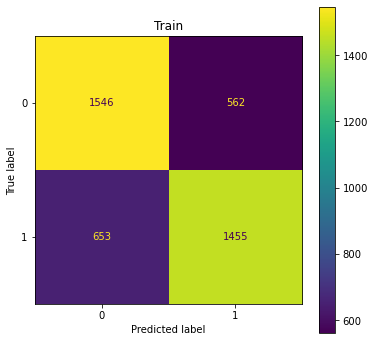

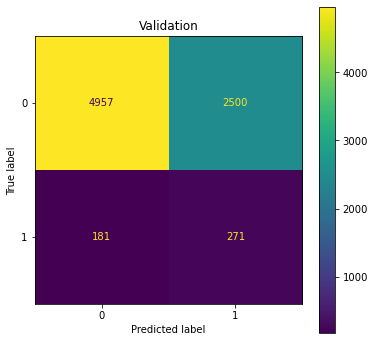

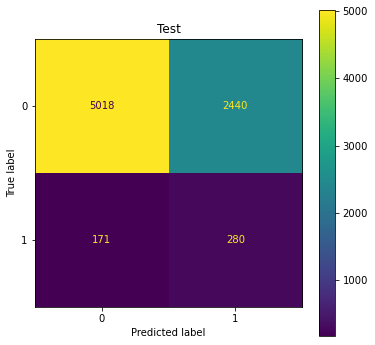

In [40]:
pp_count.fit(X_train_1, y_train_1)

scores(pp_count, X_train_1, y_train_1, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 1:1

In [41]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.6954459203036053
recall:    0.6987666034155597
Validation Scores
accuracy:  0.6521684157289164
recall:    0.6438053097345132
Test Scores
accuracy:  0.6603869009988621
recall:    0.6430155210643016


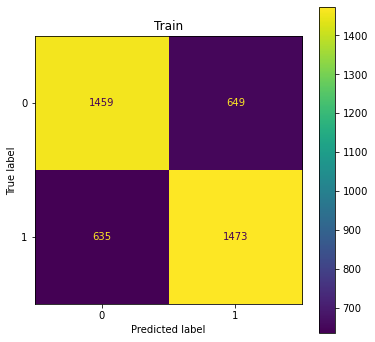

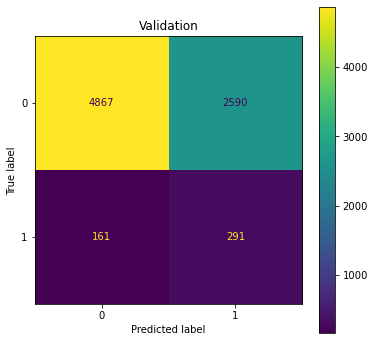

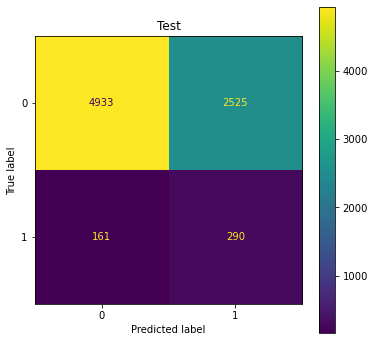

In [42]:
pp_tfidf.fit(X_train_1, y_train_1)

scores(pp_tfidf, X_train_1, y_train_1, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
log_acc, log_recall = scores(pp_tfidf, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 2:1

In [43]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_2)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7583807716635041
recall:    0.5033206831119544
Validation Scores
accuracy:  0.796560880010115
recall:    0.3805309734513274
Test Scores
accuracy:  0.8023770388165381
recall:    0.42572062084257206


(80.2, 42.6)

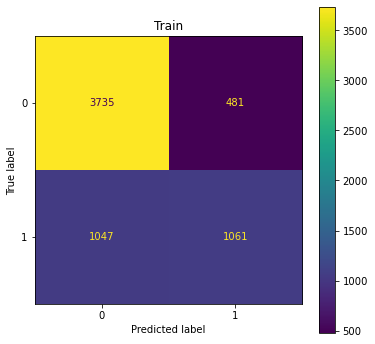

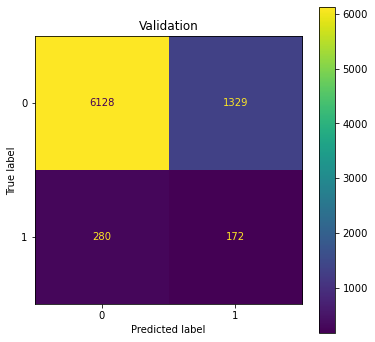

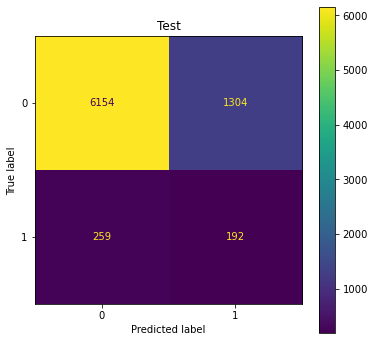

In [44]:
pp_count.fit(X_train_2, y_train_2)

scores(pp_count, X_train_2, y_train_2, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 2:1

In [45]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_2)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.7338709677419355
recall:    0.3894686907020873
Validation Scores
accuracy:  0.8511821974965229
recall:    0.3141592920353982
Test Scores
accuracy:  0.8534580857251233
recall:    0.35476718403547675


(85.3, 35.5)

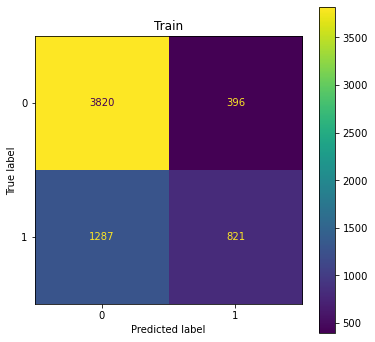

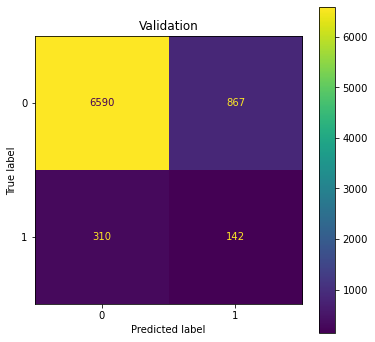

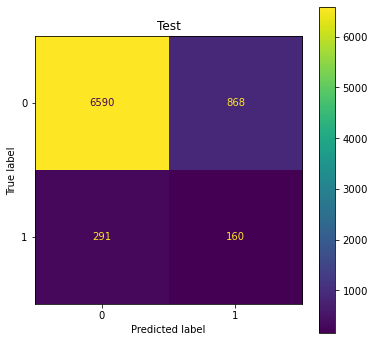

In [46]:
pp_tfidf.fit(X_train_2, y_train_2)

scores(pp_tfidf, X_train_2, y_train_2, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: Undersampling Negative 3:1

In [47]:
pp_count = Pipeline(steps=[
    ('count', CountVectorizer(stop_words=sw, max_features=max_feats_3)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.7583807716635041
recall:    0.5033206831119544
Validation Scores
accuracy:  0.796560880010115
recall:    0.3805309734513274
Test Scores
accuracy:  0.8023770388165381
recall:    0.42572062084257206


(80.2, 42.6)

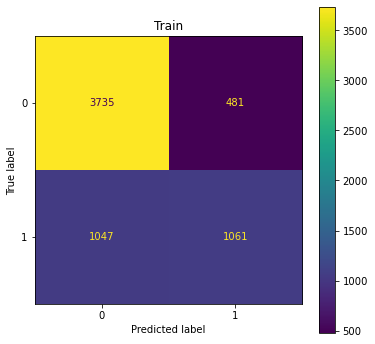

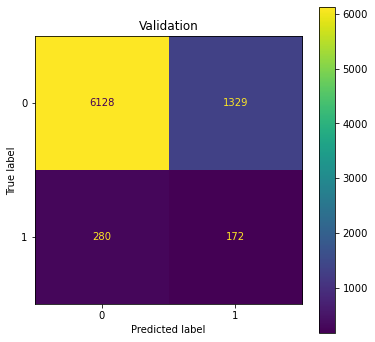

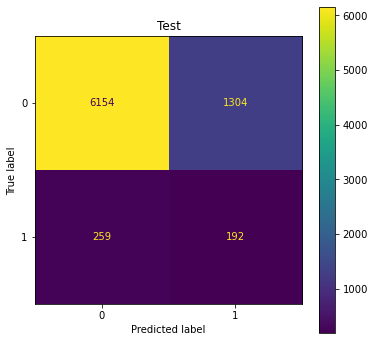

In [48]:
pp_count.fit(X_train_3, y_train_3)

scores(pp_count, X_train_3, y_train_3, 'Train')
scores(pp_count, X_val, y_val, 'Validation')
scores(pp_count, X_test, y_test, 'Test')

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Undersampling Negative 3:1

In [49]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_3)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.7338709677419355
recall:    0.3894686907020873
Validation Scores
accuracy:  0.8511821974965229
recall:    0.3141592920353982
Test Scores
accuracy:  0.8534580857251233
recall:    0.35476718403547675


(85.3, 35.5)

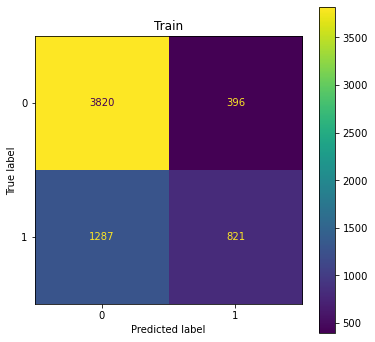

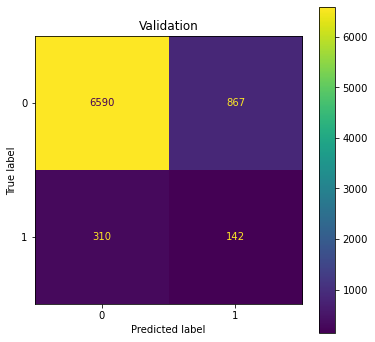

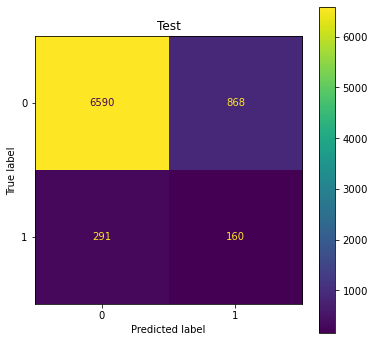

In [50]:
pp_tfidf.fit(X_train_3, y_train_3)

scores(pp_tfidf, X_train_3, y_train_3, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

After using the undersampled dataset, though the accuracy went down, the recall score went up. The ratio of 1 to 1 of negative to positive cases had the best recall scores. In addition, the tfidf vectorizer performed better than the count vectorizer, and so we will just use the tfidf vectorizer.

### Model 1.2: Logistic Regression - Class Weights

In this section, I passed in the class weights in the logistic regression model.

* Model: Logistic Regression
* Vectorizer: Tfidf
* Class Imbalance Solution: Class Weights

In [51]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('logreg', LogisticRegression(random_state=42, class_weight=class_weights)),   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:680: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":


Train Scores
accuracy:  0.9432372385390702
recall:    0.006641366223908918
Validation Scores
accuracy:  0.943229232519914
recall:    0.00663716814159292
Test Scores
accuracy:  0.943229232519914
recall:    0.004434589800443459


(94.3, 0.4)

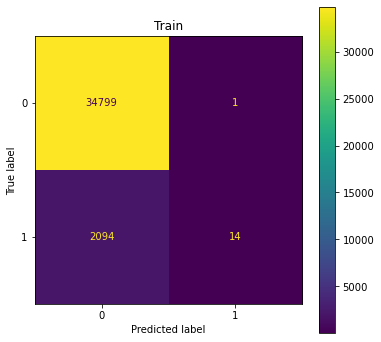

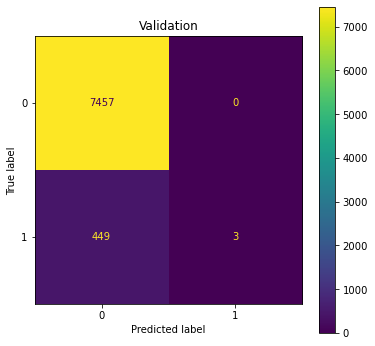

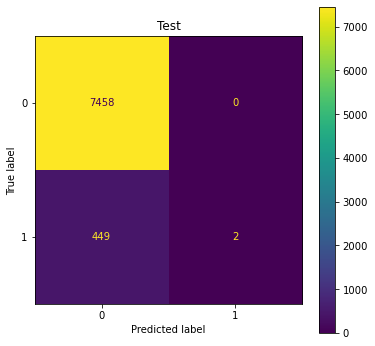

In [52]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

As seen above, passing in the class weights did not improve the recall score.

### Model 1.3: Logistic Regression - SMOTE

In this section, I utilized SMOTE to oversample the imbalanced class.

* Model: Logistic Regression
* Vectorizer: Count
* Class Imbalance Solution: SMOTE

In [53]:
pp_tfidf = imbpipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats)),
    ('smote', SMOTE(random_state=42)),
    ('logreg', LogisticRegression(random_state=42))   
    ])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Train Scores
accuracy:  0.8120461688522813
recall:    0.7722960151802657
Validation Scores
accuracy:  0.7825262359337464
recall:    0.5
Test Scores
accuracy:  0.7820204829940574
recall:    0.4878048780487805


(78.2, 48.8)

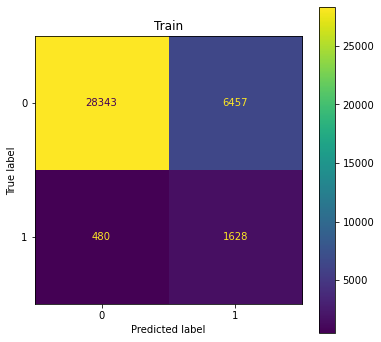

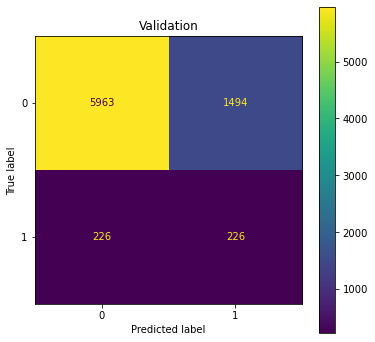

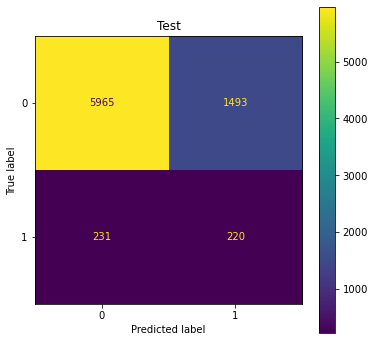

In [54]:
pp_tfidf.fit(X_train, y_train)

scores(pp_tfidf, X_train, y_train, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

SMOTE did improve the recall score. However, running SMOTE into grid search will take too much computation power. In addition, it led to the model overfitting. Therefore, I will not utilize SMOTE.

### Import Words

In [276]:
tfidf = TfidfVectorizer(stop_words=sw, max_features=max_feats_1)
logreg = LogisticRegression(random_state=42)

In [277]:
tfidf_fitted = tfidf.fit(X_train_1)
tfidf_X = tfidf_fitted.transform(X_train_1)
logreg.fit(tfidf_X, y_train_1)

LogisticRegression(random_state=42)

In [278]:
importance = get_most_important_features(tfidf_fitted, logreg, 20)

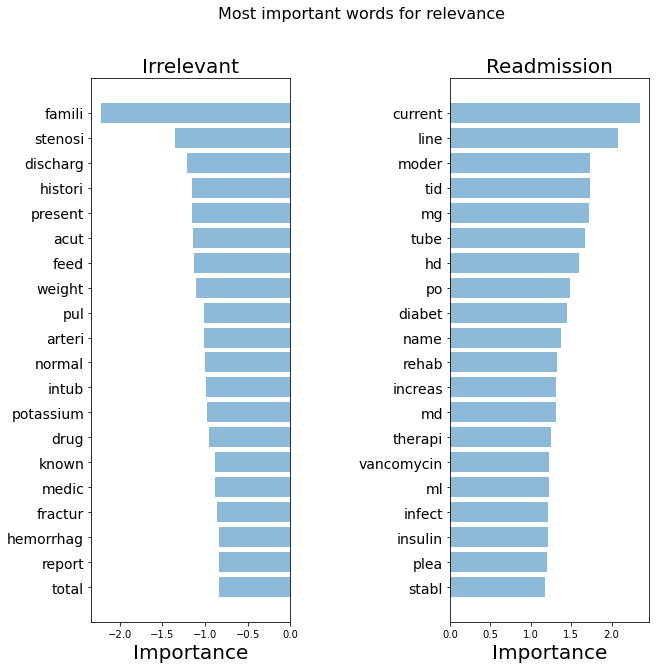

In [279]:
top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

figure = plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [280]:
#save the figure in the images folder
figure.savefig('images/Importance.png', bbox_inches='tight')

### Introducing N-Grams

I wanted to test if introducing n-grams into the data to see if it improves the score.

In [55]:
pp_tfidf = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1, ngram_range=(1,3))),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

Train Scores
accuracy:  0.6930740037950665
recall:    0.7044592030360531
Validation Scores
accuracy:  0.6412947275256038
recall:    0.6415929203539823
Test Scores
accuracy:  0.6498925275003161
recall:    0.6541019955654102


(65.0, 65.4)

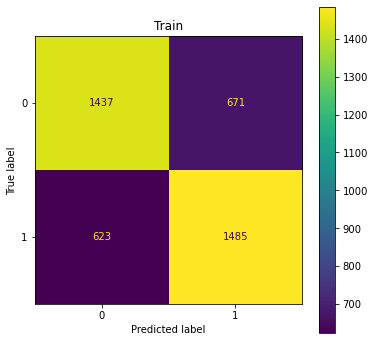

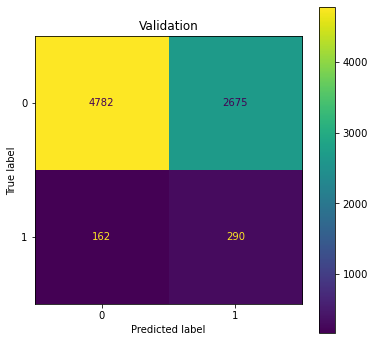

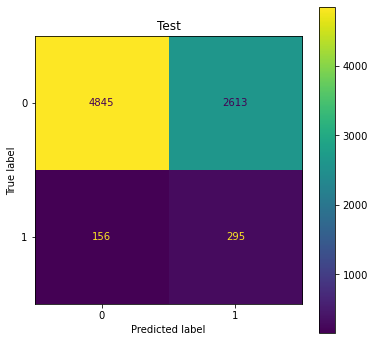

In [56]:
pp_tfidf.fit(X_train_1, y_train_1)

scores(pp_tfidf, X_train_1, y_train_1, 'Train')
scores(pp_tfidf, X_val, y_val, 'Validation')
scores(pp_tfidf, X_test, y_test, 'Test')

The scores did not improve very much. In addition, n-grams were slightly more overfitting without this model.

### Model 2: Multinomial Naives Bayes

In [57]:
mnb = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('mnb', MultinomialNB())   
    ])

Train Scores
accuracy:  0.639943074003795
recall:    0.6740986717267552
Validation Scores
accuracy:  0.6003287394107978
recall:    0.6415929203539823
Test Scores
accuracy:  0.6036161335187761
recall:    0.6629711751662971


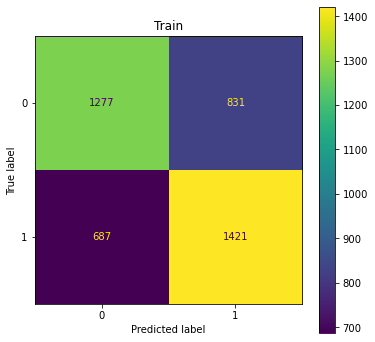

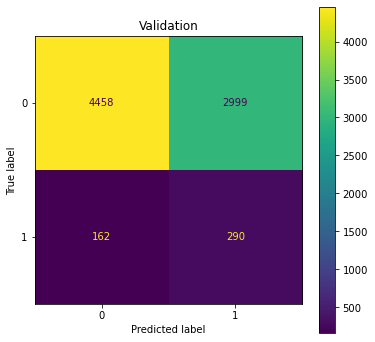

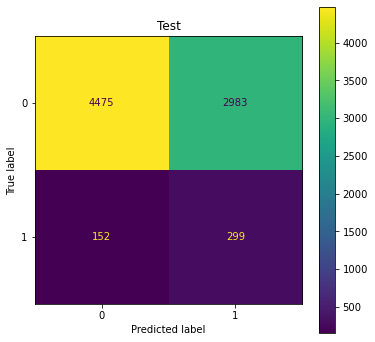

In [58]:
mnb.fit(X_train_1, y_train_1)

scores(mnb, X_train_1, y_train_1, 'Train')
scores(mnb, X_val, y_val, 'Validation')
mnb_acc, mnb_recall = scores(mnb, X_test, y_test, 'Test')

### Model 3: Random Forest

In [59]:
pp_rf = Pipeline(steps=[
    #decreased the number of features to reduce overfitting
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))), 
    ('rf', RandomForestClassifier(random_state=42))   
    ])

In [60]:
grid = {'rf__max_depth': [3,5,8,10],
        'rf__max_features': ['auto', 'sqrt'],
        'rf__min_samples_leaf': [2, 5, 10, 20, 30, 50],
        'rf__min_samples_split': [2, 5, 7, 10, 20, 50]}

In [61]:
gs_rf = GridSearchCV(estimator=pp_rf, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

In [62]:
# gs_rf.fit(X_train_1, y_train_1)

# scores(gs_rf, X_train_1, y_train_1, 'Train')
# scores(gs_rf, X_val, y_val, 'Validation')
# rf_acc, rf_recall = scores(gs_rf, X_test, y_test, 'Test')

In [63]:
# gs_rf.best_params_

In [64]:
"""
{'rf__max_depth': 3,
 'rf__max_features': 'auto',
 'rf__min_samples_leaf': 5,
 'rf__min_samples_split': 20}
"""

"\n{'rf__max_depth': 3,\n 'rf__max_features': 'auto',\n 'rf__min_samples_leaf': 5,\n 'rf__min_samples_split': 20}\n"

In [66]:
pp_rf = Pipeline(steps=[
    #decreased the number of features to reduce overfitting
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))), 
    ('rf', RandomForestClassifier(random_state=42,
                                  max_depth=3,
                                  max_features='auto',
                                  min_samples_leaf=5,
                                  min_samples_split=20))   
    ])

Train Scores
accuracy:  0.6411290322580645
recall:    0.6940227703984819
Validation Scores
accuracy:  0.5694778100897712
recall:    0.6548672566371682
Test Scores
accuracy:  0.5787078012390947
recall:    0.6784922394678492


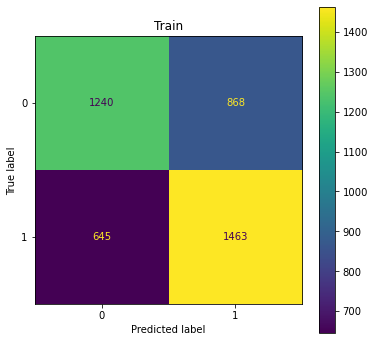

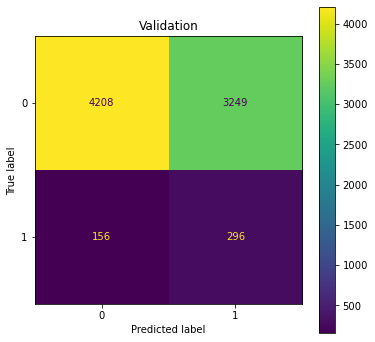

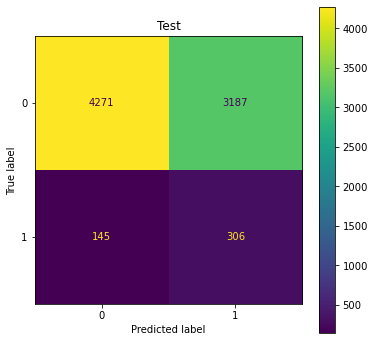

In [67]:
pp_rf.fit(X_train_1, y_train_1)

scores(pp_rf, X_train_1, y_train_1, 'Train')
scores(pp_rf, X_val, y_val, 'Validation')
rf_acc, rf_recall = scores(pp_rf, X_test, y_test, 'Test')

### Model 4: K-Nearest Neighbors

In [69]:
pp_knn = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))),
    ('knn', KNeighborsClassifier())   
    ])

In [70]:
grid = {'knn__n_neighbors': list(range(1, 20, 2)),
        'knn__weights': ['uniform', 'distance'],
        'knn__p': [1,2,3,4]}

In [71]:
gs_knn = GridSearchCV(estimator=pp_knn, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

In [72]:
# gs_knn.fit(X_train_1, y_train_1)

# scores(gs_knn, X_train_1, y_train_1, 'Train')
# scores(gs_knn, X_val, y_val, 'Validation')
# knn_acc, knn_recall = scores(gs_knn, X_test, y_test, 'Test')

In [73]:
# gs_knn.best_params_

In [74]:
"""
{'knn__n_neighbors': 19, 'knn__p': 2, 'knn__weights': 'uniform'}
"""

"\n{'knn__n_neighbors': 19, 'knn__p': 2, 'knn__weights': 'uniform'}\n"

In [75]:
pp_knn = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))),
    ('knn', KNeighborsClassifier(n_neighbors=19,
                                 p=2,
                                 weights='uniform'))   
    ])

Train Scores
accuracy:  0.6582068311195446
recall:    0.75426944971537
Validation Scores
accuracy:  0.5022126691111392
recall:    0.6504424778761062
Test Scores
accuracy:  0.514730054368441
recall:    0.7139689578713969


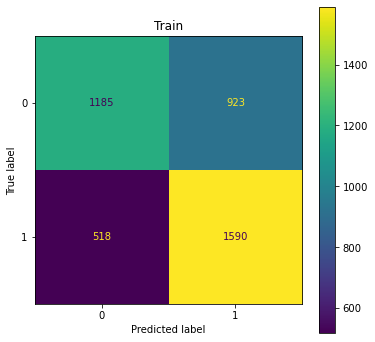

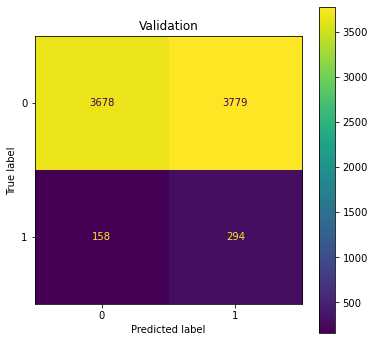

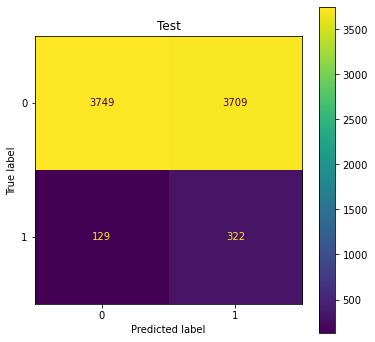

In [76]:
pp_knn.fit(X_train_1, y_train_1)

scores(pp_knn, X_train_1, y_train_1, 'Train')
scores(pp_knn, X_val, y_val, 'Validation')
knn_acc, knn_recall = scores(pp_knn, X_test, y_test, 'Test')

### Model 5: Decision Tree Model

In [77]:
pp_dt = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('dt', DecisionTreeClassifier(random_state=42, criterion='entropy'))   
    ])

In [78]:
grid = {'dt__max_depth': np.arange(1, 17, 3),
        'dt__min_samples_split': np.arange(20, 101, 10),
        'dt__min_samples_leaf': np.arange(20, 101, 10)
       }

In [79]:
gs_dt = GridSearchCV(estimator=pp_dt, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

In [80]:
# gs_dt.fit(X_train_1, y_train_1)

# scores(gs_dt, X_train_1, y_train_1, 'Train')
# scores(gs_dt, X_val, y_val, 'Validation')
# dt_acc, dt_recall = scores(gs_dt, X_test, y_test, 'Test')

In [81]:
# gs_dt.best_params_

In [82]:
"""
{'dt__max_depth': 1, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 20}
"""

"\n{'dt__max_depth': 1, 'dt__min_samples_leaf': 20, 'dt__min_samples_split': 20}\n"

In [84]:
pp_dt = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('dt', DecisionTreeClassifier(random_state=42,
                                  criterion='entropy',
                                  max_depth=1,
                                  min_samples_leaf=20,
                                  min_samples_split=20))   
    ])

Train Scores
accuracy:  0.601280834914611
recall:    0.5531309297912713
Validation Scores
accuracy:  0.6354785687191806
recall:    0.5619469026548672
Test Scores
accuracy:  0.6357314451890251
recall:    0.5343680709534369


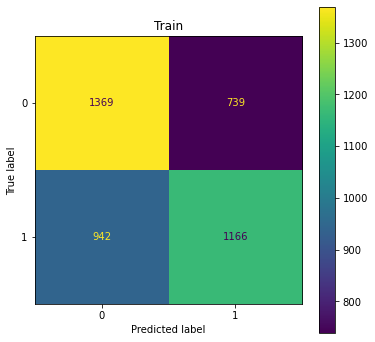

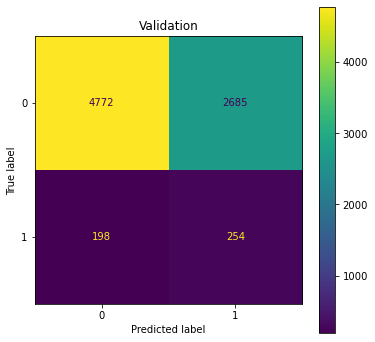

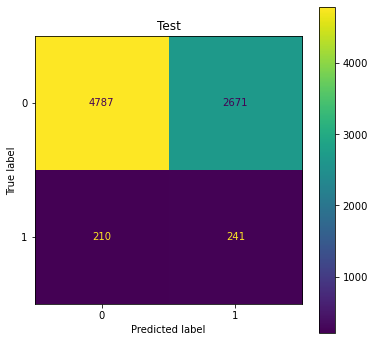

In [85]:
pp_dt.fit(X_train_1, y_train_1)

scores(pp_dt, X_train_1, y_train_1, 'Train')
scores(pp_dt, X_val, y_val, 'Validation')
dt_acc, dt_recall = scores(pp_dt, X_test, y_test, 'Test')

### Model 6: Gradient Boost

In [86]:
pp_gbc = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))),
    ('gbc', GradientBoostingClassifier(random_state=42))   
    ])

In [87]:
grid = {'gbc__max_features': ['auto','log2'],
        'gbc__min_samples_split':[500, 600, 700, 800, 900, 1000],
        'gbc__min_samples_leaf':[5, 10, 20, 50, 100],
        'gbc__max_depth':[2, 3, 5, 10, 20]
       }

In [88]:
gs_gbc = GridSearchCV(estimator=pp_gbc, 
                      param_grid=grid, 
                      scoring='recall', 
                      cv=3,
                      verbose=2,
                      n_jobs=-1
                     )

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Train Scores
accuracy:  0.6871442125237192
recall:    0.7234345351043643
Validation Scores
accuracy:  0.6026046276393981
recall:    0.6592920353982301
Test Scores
accuracy:  0.6113288658490328
recall:    0.6585365853658537


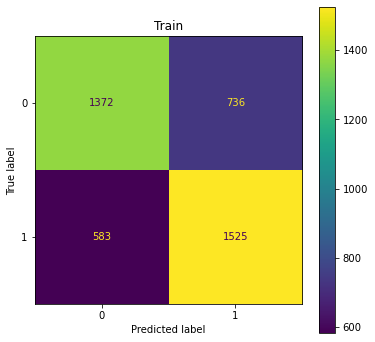

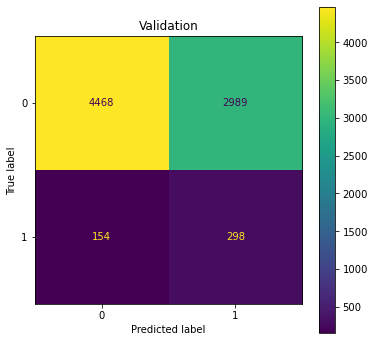

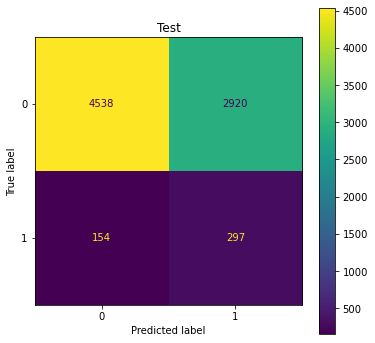

In [91]:
# gs_gbc.fit(X_train_1, y_train_1)

# scores(gs_gbc, X_train_1, y_train_1, 'Train')
# scores(gs_gbc, X_val, y_val, 'Validation')
# scores(gs_gbc, X_test, y_test, 'Test')

In [92]:
gs_gbc.best_params_

{'gbc__max_depth': 2,
 'gbc__max_features': 'log2',
 'gbc__min_samples_leaf': 50,
 'gbc__min_samples_split': 500}

In [93]:
"""
{'gbc__max_depth': 3,
 'gbc__max_features': 'auto',
 'gbc__min_samples_split': 1000
"""

"\n{'gbc__max_depth': 3,\n 'gbc__max_features': 'auto',\n 'gbc__min_samples_split': 1000\n"

In [94]:
pp_gbc = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1*0.1))),
    ('gbc', GradientBoostingClassifier(random_state=42,
                                       max_depth= 2,
                                       max_features= 'log2',
                                       #I adjusted parameters to decrease overfitting
                                       min_samples_leaf= 100, 
                                       min_samples_split= 500))   
    ])

Train Scores
accuracy:  0.6842979127134725
recall:    0.7210626185958254
Validation Scores
accuracy:  0.6057655835124541
recall:    0.6637168141592921
Test Scores
accuracy:  0.6105702364394993
recall:    0.6629711751662971


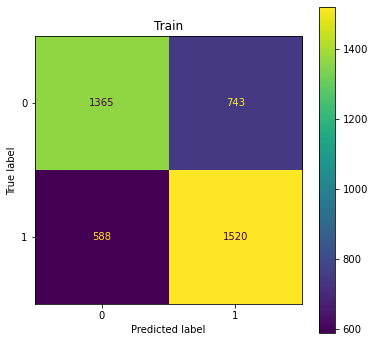

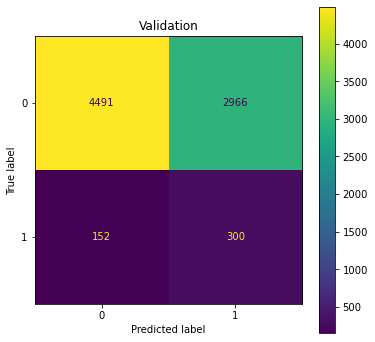

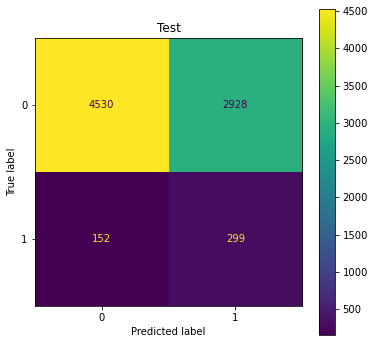

In [96]:
pp_gbc.fit(X_train_1, y_train_1)

scores(pp_gbc, X_train_1, y_train_1, 'Train')
scores(pp_gbc, X_val, y_val, 'Validation')
gbc_acc, gbc_recall = scores(pp_gbc, X_test, y_test, 'Test')

### Model X: Neural Networks

In [ ]:
tfidf = TfidfVectorizer(stop_words=sw, max_features=int(max_feats_1))

In [ ]:
X_train_1_vec = tfidf.fit_transform(X_train_1)
X_val_vec = tfidf.transform(X_val)
X_test_vec = tfidf.transform(X_test)

In [ ]:
np.random.seed(123)
model2 = models.Sequential()
model2.add(layers.Dense(50, activation='relu'))
model2.add(layers.Dense(25, activation='relu'))
model2.add(layers.Dense(7, activation='relu'))
model2.add(layers.Dense(5, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
X_train_1_vec.shape

In [ ]:
y_train_1.shape

In [ ]:
# model2.compile(optimizer='sgd',
#               loss='categorical_crossentropy',
#               metrics=['acc'])

# history2 = model2.fit(x=X_train_1_vec,
#                       y=y_train_1,
#                       epochs=30,
#                       batch_size=50,
#                      # validation_data=(X_val, y_val)
#                      )

### Model 7: Ensemble

In [115]:
pp_logreg = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(stop_words=sw, max_features=max_feats_1)),
    ('logreg', LogisticRegression(random_state=42)),   
    ])

In [140]:
voting_clf = VotingClassifier(estimators={("logreg", pp_logreg),
                                          ("mnb", mnb),
                                          ("rf", pp_rf),
                                          ('knn', pp_knn),
                                          #('dt', pp_dt),
                                          ("gbc", pp_gbc)
                                        },
                              voting= "soft")

Train Scores
accuracy:  0.6904648956356736
recall:    0.7281783681214421
Validation Scores
accuracy:  0.6089265393855102
recall:    0.6592920353982301
Test Scores
accuracy:  0.6215703628777343
recall:    0.7006651884700665


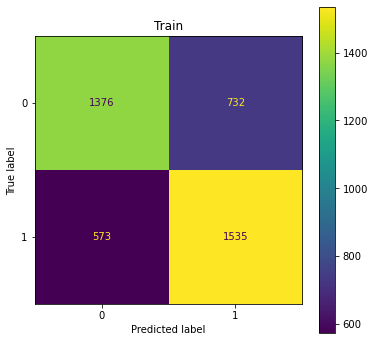

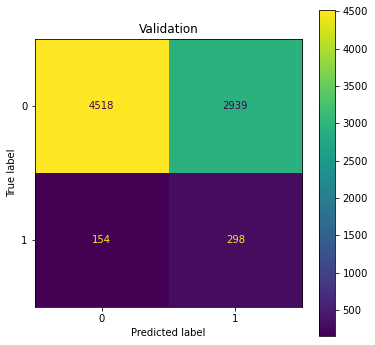

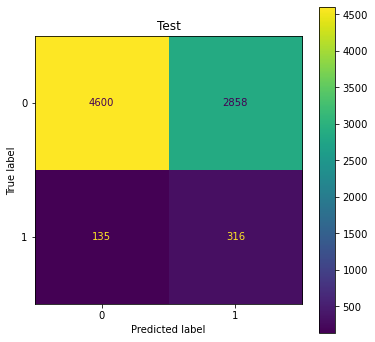

In [141]:
voting_clf.fit(X_train_1, y_train_1)

scores(voting_clf, X_train_1, y_train_1, 'Train')
scores(voting_clf, X_val, y_val, 'Validation')
vot_acc, vot_recall = scores(voting_clf, X_test, y_test, 'Test')

## Reviewing All Models:

In [142]:
X_labels = ['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6', 'Model 7']
y1 = [log_recall, mnb_recall, rf_recall, knn_recall, dt_recall, gbc_recall, vot_recall]

In [143]:
y2 = [log_acc, mnb_acc, rf_acc, knn_acc, dt_acc, gbc_acc, vot_acc]

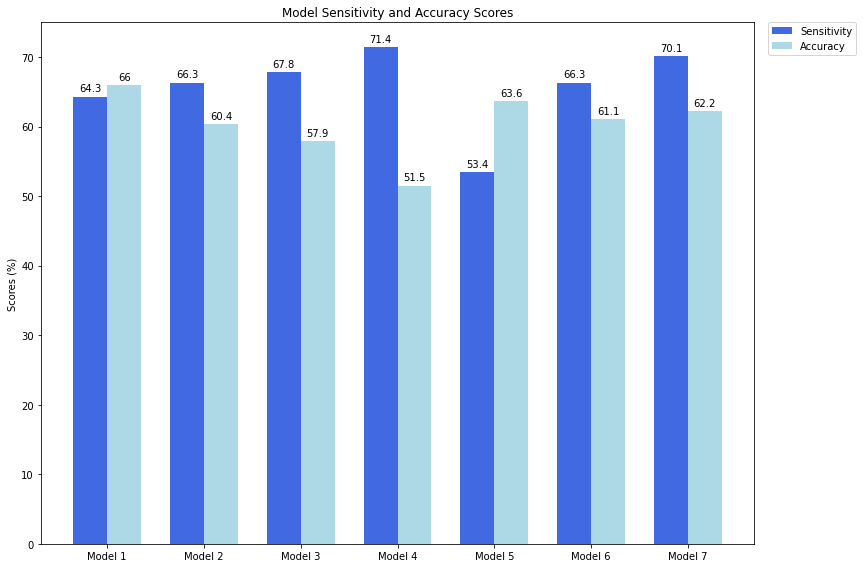

In [232]:
width = 0.35  # the width of the bars
x = np.arange(len(X_labels))
fig, ax = plt.subplots(figsize=(12,8))
rects1 = ax.bar(x - width/2, y1, width, label='Sensitivity', color='royalblue')
rects2 = ax.bar(x + width/2, y2, width, label='Accuracy', color='lightblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores (%)')
ax.set_title('Model Sensitivity and Accuracy Scores')
ax.set_xticks(x)
ax.set_xticklabels(X_labels)
ax.legend(bbox_to_anchor=(1.15, 1.01))

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()
#save the figure in the images folder
fig.savefig('images/Model_Scores.png', bbox_inches='tight')

## Setting Final Model

In [146]:
#split the positive and negative data
df_pos = df[df['READMISSION']==1]
df_neg = df[df['READMISSION']==0]

In [147]:
#take a sample of the negative training set with the same number of rows as positive dataset
df_neg_samp = df_neg.sample(n=len(df_pos), random_state=42)

In [148]:
#concat the positive dataset and sample of the negative dataset to get one dataset
#with equal number of postiive and negative cases
new_df = pd.concat([df_pos,df_neg_samp],axis=0)

In [149]:
#randomize the new dataset
new_df = new_df.sample(n=len(new_df), random_state=42)

In [150]:
#split out the X and y of the new dataset
new_y = new_df['READMISSION']
new_X = new_df['TEXT']
new_max_feats = int(new_X.shape[0]*0.10)

In [151]:
final_model = voting_clf

Final Scores
accuracy:  0.6353601638660243
recall:    0.7143806044503487


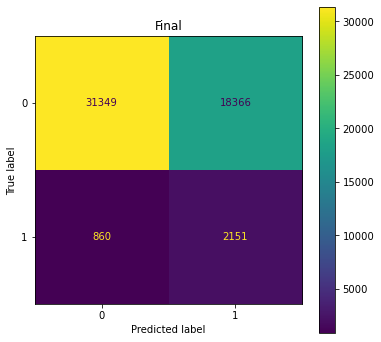

In [152]:
final_model.fit(new_X, new_y)
final_acc, final_recall = scores(final_model, X, y, 'Final')

In [153]:
y_preds = final_model.predict(X)
y_probs = final_model.predict_proba(X)

In [154]:
y_preds = pd.DataFrame(y_preds)
y_probs = pd.DataFrame(y_probs)

In [155]:
y_probs.drop(0, axis=1, inplace=True)

## Merging Results to Other Features and Exporting Data

In [156]:
new_df1 = df.copy()
new_df2 = df.copy()

new_df1 = new_df1.merge(y_preds, left_index=True, right_index=True)
new_df1.drop('TEXT', axis=1, inplace=True)
new_df1.rename(columns={0: 'TEXT'}, inplace=True)
                        
new_df2 = new_df2.merge(y_probs, left_index=True, right_index=True)
new_df2.drop('TEXT', axis=1, inplace=True)
new_df2.rename(columns={1: 'TEXT'}, inplace=True)

In [157]:
#export the modified dataframe with predicted classifications to the data folder
new_df1.to_csv("data/admissions_nlp_processed_1.csv.gz" , index = False,compression='gzip')

In [158]:
#export the modified dataframe with predicted probabilites to the data folder
new_df2.to_csv("data/admissions_nlp_processed_2.csv.gz" , index = False,compression='gzip')